In [1]:
# Ignore anoying warnings
import warnings
warnings.filterwarnings("ignore")

# Import all usefull libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ppscore as pps 

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import SelectKBest, chi2, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.manifold import TSNE

%matplotlib inline

In [2]:
# Loading the cleanned data
telecom = pd.read_csv("Churn_Cleaned_Data.csv")

# Showing first 5 rows from data set
telecom.head()

,account_length,voice_plan,voice_messages,intl_plan,intl_mins,intl_calls,intl_charge,day_mins,day_calls,day_charge,eve_mins,eve_calls,eve_charge,night_mins,night_calls,night_charge,customer_calls,churn
0,128,1,25.0,0,10.0,3.0,2.70,265.1,110,45.07,197.40,99.0,16.78,244.7,91,11.01,1.0,0
1,107,1,26.0,0,13.7,3.0,3.70,161.6,123,27.47,195.50,103.0,16.62,254.4,103,11.45,1.0,0
2,137,0,0.0,0,12.2,5.0,3.29,243.4,114,41.38,121.20,110.0,10.30,162.6,104,7.32,0.0,0
3,84,0,0.0,1,6.6,7.0,1.78,299.4,71,50.90,65.65,88.0,5.50,196.9,89,8.86,2.0,0
4,75,0,0.0,1,10.1,3.0,2.73,166.7,113,28.34,148.30,122.0,12.61,186.9,121,8.41,3.0,0


# Feature Selection :

## Correlation Analysis :
- *For understanding about correlation, we use `heatmap()` for visualize the correlation between each columns.*

<AxesSubplot: >

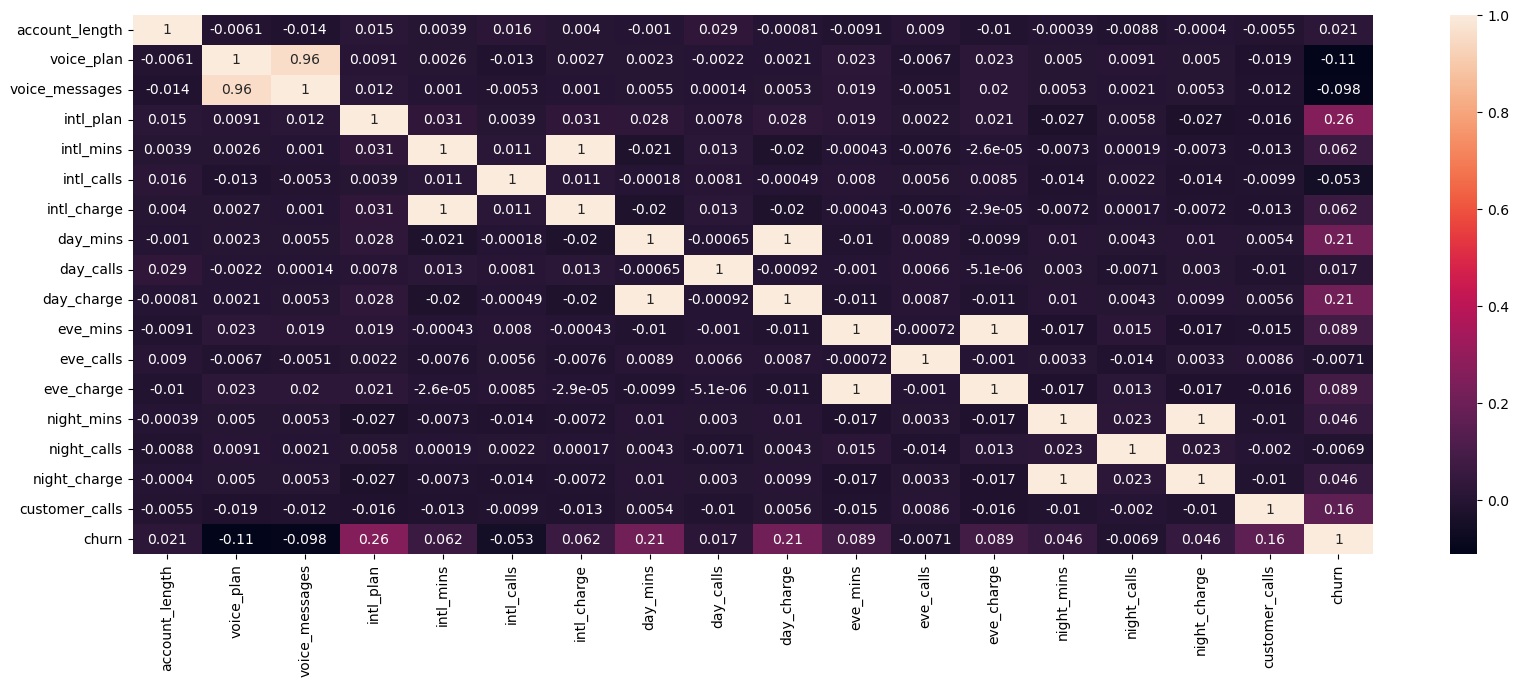

In [3]:
plt.figure(figsize=(20,7))
sns.heatmap(telecom.corr(), annot=True)

- *In above heatmap we see that the high multicollinearity occurs in `intl_mins, intl_charge, day_mins, day_charge, eve_mins, eve_charge, night_mins, night_charge` columns.*
- *For reducing multicollinearity, we calculating VIF values for this columns.*

In [4]:
# Select the columns for which VIF values need to be calculated
cols = ['intl_mins', 'intl_charge', 'day_mins', 'day_charge', 'eve_mins', 'eve_charge', 'night_mins', 'night_charge']

# Calculate the VIF values for the selected columns
X = telecom[cols]
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

# Sort the VIF values in decreasing order
vif_sorted = vif.sort_values('VIF Factor', ascending=False)

# Show the VIF values
vif_sorted

,VIF Factor,features
7,1.058614e+07,night_charge
6,1.058583e+07,night_mins
1,8.636260e+05,intl_charge
0,8.625603e+05,intl_mins
3,2.635939e+04,day_charge
2,2.635581e+04,day_mins
4,3.610960e+03,eve_mins
5,3.599227e+03,eve_charge


- *Compare VIF values between charge & mins columns.*
- *Drop those relevent columns which shows high VIF values.*

<AxesSubplot: >

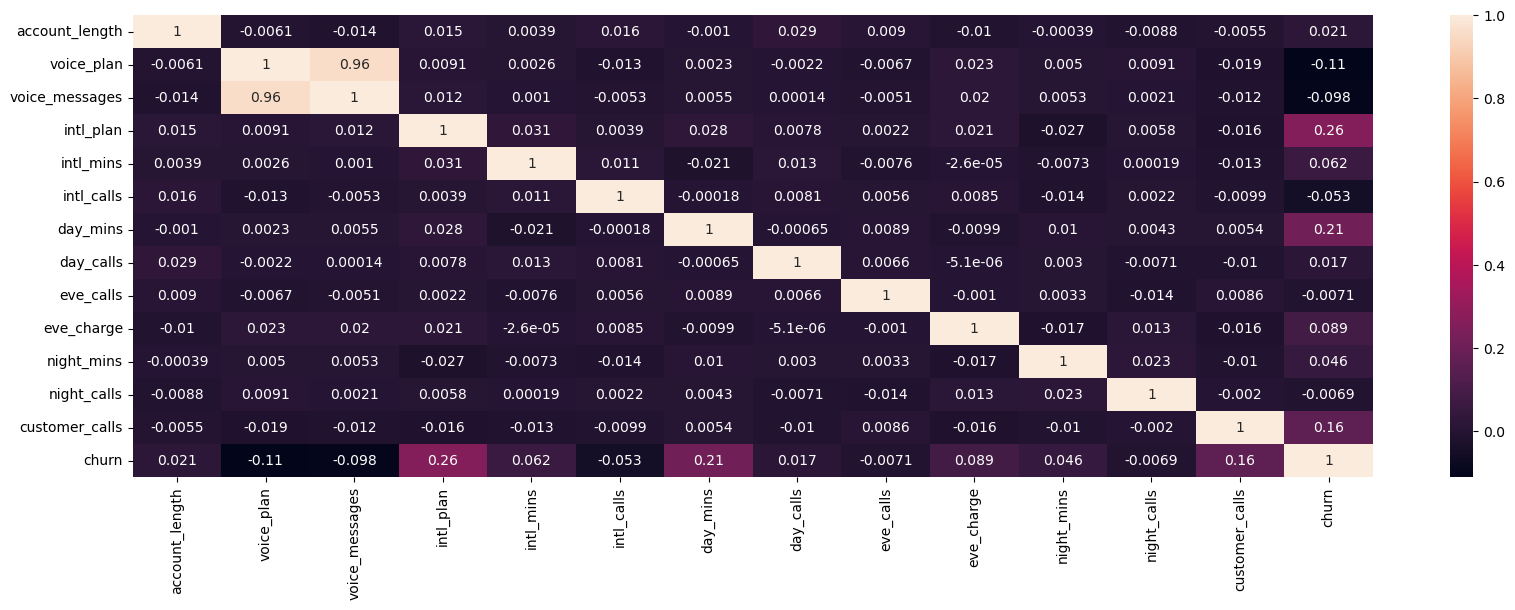

In [5]:
# Droping columns which is high VIF value
telecom.drop(['night_charge','intl_charge','day_charge','eve_mins'], axis=1, inplace=True)

# Checking that the multicollinearity is reduced or not
plt.figure(figsize=(20,6))
sns.heatmap(telecom.corr(), annot=True)

- *As we see in above heatmap multicollinearity is reduced.*

In [6]:
# After reducing multicollinearity, checking the dimensions of dataset
telecom.shape

(5000, 14)

- *After reducing multicollinearity, we have 5000 rows & 14 columns in telecom dataset.*

In [7]:
# Defining independent (x) & dependent (y) variables for feature selection

x = telecom.iloc[:,:-1]
y = telecom['churn']

## Univariate Selection :

In [8]:
# Using chisquare for feature selection
test = SelectKBest(score_func=chi2, k=10)

# Fitting independent & dependent variables in SelectKBest
chi_score = test.fit(x,y)

# Creating dataframe for scores of chisquare
uni_select = pd.DataFrame()
uni_select['Features'] = x.columns
uni_select['Chi2_scores'] = chi_score.scores_

# Show dataframe with sorted Chi_scores in decreasing order
uni_select.sort_values('Chi2_scores', ascending=False)

,Features,Chi2_scores
6,day_mins,3419.438136
2,voice_messages,1127.015169
3,intl_plan,303.963357
10,night_mins,132.451969
12,customer_calls,103.570015
1,voice_plan,45.058340
9,eve_charge,41.927232
0,account_length,34.895782
5,intl_calls,16.183508
4,intl_mins,13.652515


<AxesSubplot: xlabel='Chi2_scores', ylabel='Features'>

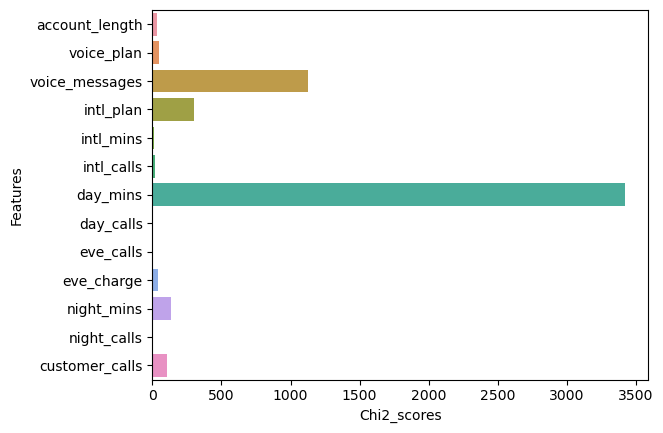

In [9]:
# Visualize the Univariate Selection
sns.barplot(x='Chi2_scores', y='Features', data=uni_select)

## Tree Based Method : 

In [10]:
# Creating object for DecisionTreeClassifier()
dt = DecisionTreeClassifier()

# Fitting independent & dependent variables in DecisionTreeClassifier
dt_score = dt.fit(x,y)

# Creating dataframe for Tree Based Method
tree_method = pd.DataFrame()
tree_method['Features'] = x.columns
tree_method['Tree_scores'] = pd.Series(dt_score.feature_importances_).sort_values(ascending=False)

# Show dataframe with sorted by Tree_scores in decreasing order
tree_method.sort_values('Tree_scores', ascending=False)

,Features,Tree_scores
6,day_mins,0.259571
9,eve_charge,0.139978
4,intl_mins,0.108178
12,customer_calls,0.107641
5,intl_calls,0.079035
10,night_mins,0.069492
3,intl_plan,0.067817
1,voice_plan,0.040940
11,night_calls,0.030809
7,day_calls,0.026925


<AxesSubplot: xlabel='Tree_scores', ylabel='Features'>

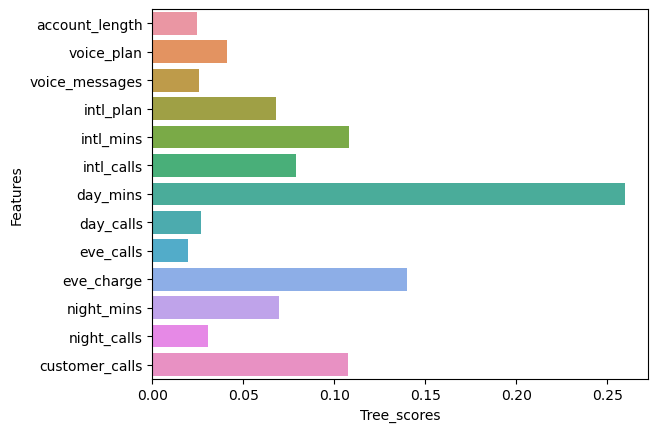

In [11]:
# Visualize the tree based method
sns.barplot(x='Tree_scores', y='Features', data=tree_method)

## Recursive Feature Elimination [RFE] :

In [12]:
# Creating object for LogisticRegrassion()
lg = LogisticRegression()

# Creating object for RFE with LogisticRegression estimator
rfe = RFE(estimator=lg, n_features_to_select=10)

# Fitting independent & dependent variables into RFE
rfe.fit(x,y)

RFE(estimator=LogisticRegression(), n_features_to_select=10)

In [13]:
# Final number of features selected by RFE after recursively eliminating the least important features.
rfe.n_features_

10

In [14]:
rfe.support_

array([False,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False,  True])

- *It is a boolean array that indicates whether each feature in the input data was selected or not by the `RFE` algorithm.*

In [15]:
# Creating dataframe for features, Support & ranking
rfe_data = pd.DataFrame({'Features': x.columns, 'Support': rfe.support_, 'Ranking': rfe.ranking_})

# Sorting the data by the "Ranking" column
rfe_data = rfe_data.sort_values(by='Ranking')

# Showing dataframe
rfe_data

,Features,Support,Ranking
1,voice_plan,True,1
2,voice_messages,True,1
3,intl_plan,True,1
4,intl_mins,True,1
5,intl_calls,True,1
6,day_mins,True,1
7,day_calls,True,1
8,eve_calls,True,1
9,eve_charge,True,1
12,customer_calls,True,1


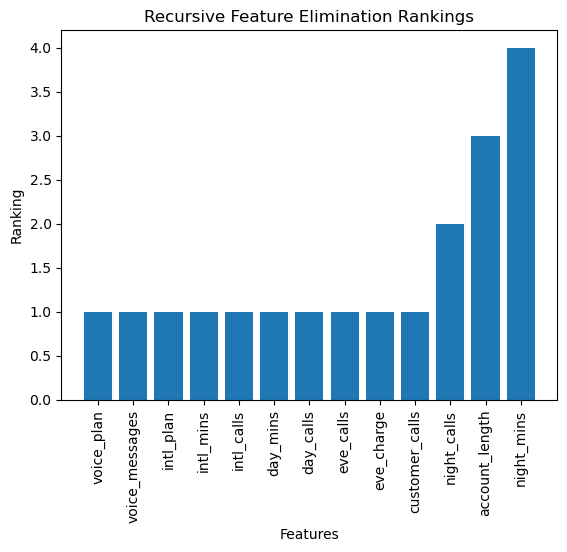

In [16]:
# Create a bar plot of the features and their rankings
plt.bar(rfe_data['Features'], rfe_data['Ranking'])
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Ranking')
plt.title('Recursive Feature Elimination Rankings')
plt.show()

- *In above graph, only `First` ranked columns are important than other columns.*

## T-distributed Stochastic Neighbor Embedding `[t-SNE]` :

In [17]:
# Defining t-SNE model with 2 components (for 2D visualization)
tsne = TSNE(n_components=2)

# Fit & transform the indepentent feature X
X_tsne = tsne.fit_transform(x)

# Show transformed output
X_tsne

array([[  3.410046, -60.171177],
       [ 49.551327, -14.998888],
       [-52.919674, -23.41594 ],
       ...,
       [ 15.441003,  20.853428],
       [ 22.631386, -38.35733 ],
       [-13.921532,  61.62856 ]], dtype=float32)

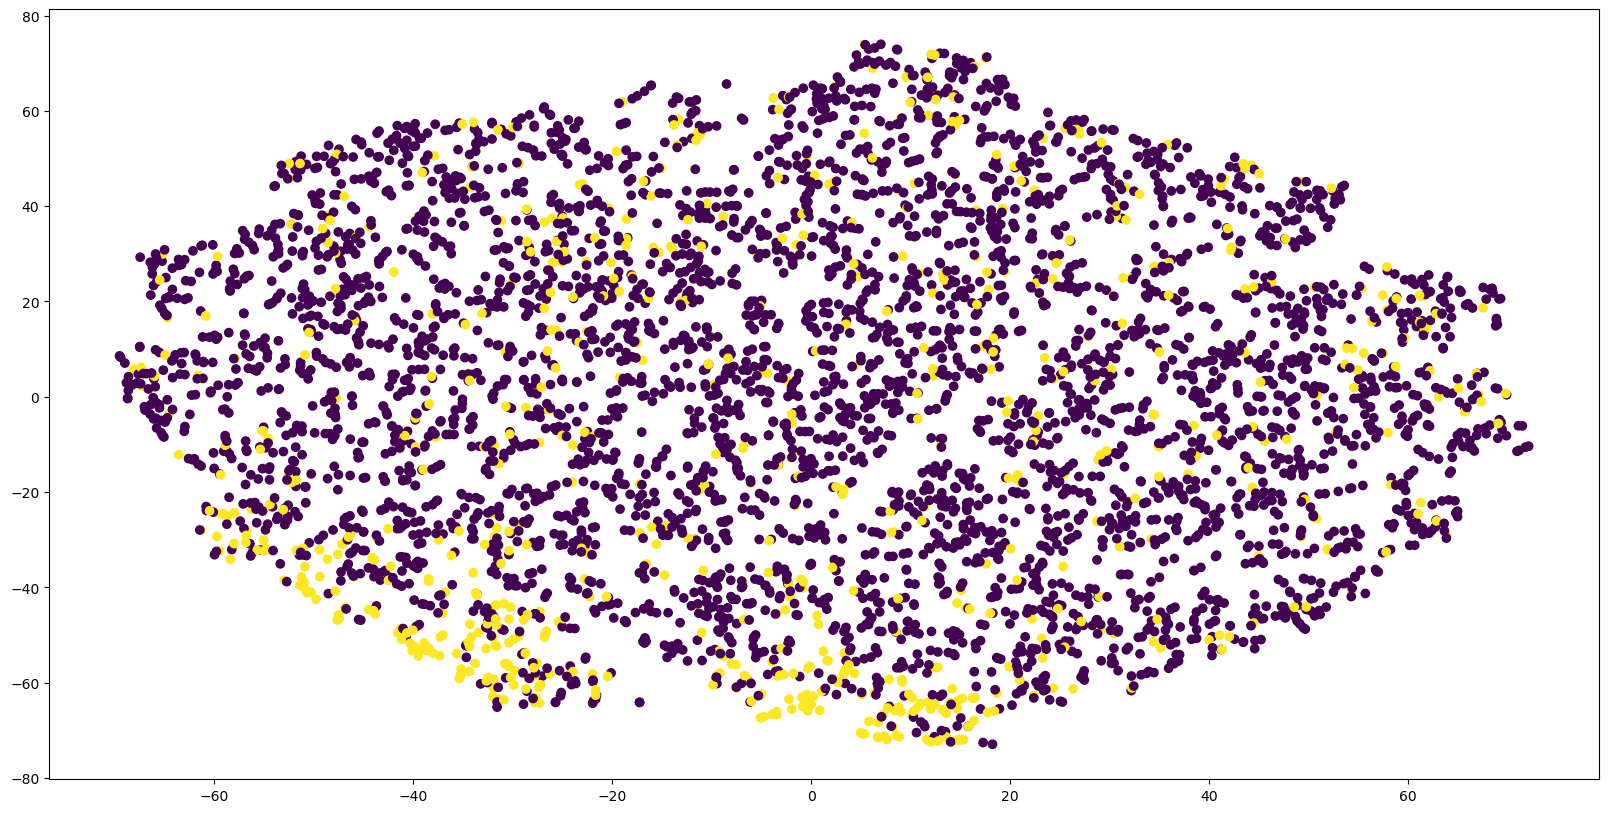

In [18]:
# Visualize the t-SNE plot
plt.figure(figsize=(20,10))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y)
plt.show()

## Predictive Power Score [PPScore] : 

In [19]:
# Creating an empty dictionary to store the PPS scores for each pair of columns
pps_scores = {}

# Iterate through all the columns in the dataframe
for col in telecom.columns:

    # Calculating the PPS scores for the current column & the target column "churn"
    if col != 'churn':
        pps_score = pps.score(df=telecom, x=col, y='churn')['ppscore']
        pps_scores[(col, 'churn')] = pps_score

# Print the PPS scores for each pair of columns
for col_pair, pps_score in pps_scores.items():
    print(f"PPS between columns {col_pair} & 'churn': {pps_score}")

PPS between columns ('account_length', 'churn') & 'churn': 0
PPS between columns ('voice_plan', 'churn') & 'churn': 0
PPS between columns ('voice_messages', 'churn') & 'churn': 0
PPS between columns ('intl_plan', 'churn') & 'churn': 0
PPS between columns ('intl_mins', 'churn') & 'churn': 0
PPS between columns ('intl_calls', 'churn') & 'churn': 0
PPS between columns ('day_mins', 'churn') & 'churn': 0
PPS between columns ('day_calls', 'churn') & 'churn': 0
PPS between columns ('eve_calls', 'churn') & 'churn': 0
PPS between columns ('eve_charge', 'churn') & 'churn': 0
PPS between columns ('night_mins', 'churn') & 'churn': 0
PPS between columns ('night_calls', 'churn') & 'churn': 0
PPS between columns ('customer_calls', 'churn') & 'churn': 0


# Final Data Set :
- *Selecting only comman columns from `univariate selection, tree based method & RFE`.*

In [20]:
# Selecting only comman columns
final_df = telecom[['account_length','voice_messages','intl_plan','intl_mins','intl_calls', 
                   'day_mins','eve_charge','night_mins','customer_calls','churn']]

# Show first 5 rows from final dataset
final_df.head()

,account_length,voice_messages,intl_plan,intl_mins,intl_calls,day_mins,eve_charge,night_mins,customer_calls,churn
0,128,25.0,0,10.0,3.0,265.1,16.78,244.7,1.0,0
1,107,26.0,0,13.7,3.0,161.6,16.62,254.4,1.0,0
2,137,0.0,0,12.2,5.0,243.4,10.30,162.6,0.0,0
3,84,0.0,1,6.6,7.0,299.4,5.50,196.9,2.0,0
4,75,0.0,1,10.1,3.0,166.7,12.61,186.9,3.0,0


In [21]:
# Dimensions of finalize data
final_df.shape

(5000, 10)

In [22]:
# Saving that data which we use for model building purpose
final_df.to_csv('Churn_Model_Building_Data.csv', index=False)